In [ ]:
# Import necessary packages

In [25]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
from tqdm import tqdm
import shutil
import pandas as pd
from sklearn.cluster import KMeans
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import multiprocessing

np.random.seed(123)
random.seed(123)

In [ ]:
# Set the location of dictionary
# Create the doctionary of training data and augmented data

In [2]:
mask_dir = r"C:\Users\lolo\Desktop\Spring2025\CODE\mask"
raw_dir = r"C:\Users\lolo\Desktop\Spring2025\CODE\raw"
output_dir = r"C:\Users\lolo\Desktop\Spring2025\CODE\results"
training_dir = os.path.join(output_dir, 'training_data')
augmented_dir = os.path.join(output_dir, 'augmented_data')

os.makedirs(output_dir, exist_ok=True)

In [3]:
# This function is to locate the bands in masks
# We gonna use images in mask_dir and raw_dir
# Output will be saved in output_dir

In [4]:
def locate_bands_in_masks(mask_dir, raw_dir, output_dir=None, output_method='center'):
    if output_dir:
        os.makedirs(output_dir, exist_ok=True) # Make sure our output file
        
    # Initialize the result dictionary
    results = {}
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.startswith('Mask_') and f.endswith('.tif')])

    # Use tqdm to show the process
    for mask_file in tqdm(mask_files, desc="Processing masks"):
        # Get the number of 
        mask_number = mask_file.split('_')[1].split('.')[0]
        raw_file = f"Gel_{mask_number}.tif"
        
        mask_path = os.path.join(mask_dir, mask_file)
        raw_path = os.path.join(raw_dir, raw_file)

        # Convert mask images to grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Set thresholds as 127,
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        # Find the different regions on Masks
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

        # Initialize bands
        bands = []
        # Go through each label area
        for i in range(1, num_labels):
            if output_method == 'center':
                x, y = map(int, centroids[i])
                bands.append((x, y))
            elif output_method == 'topleft':
                left = stats[i, cv2.CC_STAT_LEFT]
                top = stats[i, cv2.CC_STAT_TOP]
                bands.append((left, top))
            elif output_method == 'bottomleft':
                left = stats[i, cv2.CC_STAT_LEFT]
                top = stats[i, cv2.CC_STAT_TOP]
                height = stats[i, cv2.CC_STAT_HEIGHT]
                bands.append((left, top + height - 1))

        # Order bands by y axis
        bands = sorted(bands, key=lambda pos: pos[1])
        # Save the results
        results[mask_file] = bands

        # Output
        if output_dir:
            # Turn raw files into RGB, OpenCV: BGR
            raw_img = cv2.imread(raw_path)
            raw_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

            # Test the output
            for i, (x, y) in enumerate(bands):
                cv2.circle(raw_rgb, (x, y), 5, (255, 0, 0), -1)
                # Add text label
                cv2.putText(raw_rgb, f"Band {i+1}", (x + 10, y), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            
            # Use matplotlib to save result
            plt.figure(figsize=(10, 8))
            plt.imshow(raw_rgb)
            plt.title(f"Detected Bands in {raw_file}")
            plt.axis('on')
            plt.savefig(os.path.join(output_dir, f"detected_bands_{mask_number}.png"), dpi=300)
            plt.close()

        # Print log
        print(f"File: {mask_file} -> {raw_file}")
        for i, band in enumerate(bands):
            print(f"  Band {i+1}: {band}")
    
    return results

In [5]:
def process_image(gel_file, raw_dir, mask_dir, window_size=50, stride=25):

    # Extract gel ID from filename 
    gel_number = gel_file.split('_')[1].split('.')[0]
    
    # Construct corresponding mask filename 
    mask_file = f"Mask_{gel_number}.tif"
    
    # Build full file paths
    gel_path = os.path.join(raw_dir, gel_file)    # Path to raw gel image
    mask_path = os.path.join(mask_dir, mask_file) # Path to mask file
    
    # Check mask existence 
    if not os.path.exists(mask_path):
        return None, None, None, None
    
    # Load raw image as grayscale (single channel)
    img = cv2.imread(gel_path, cv2.IMREAD_GRAYSCALE)
    
    # Get image dimensions
    height, width = img.shape[:2]  # Grayscale image has no channel dimension
    
    # Initialize storage containers
    windows = []    # Stores image window arrays
    positions = []  # Stores (x,y) coordinates of window top-left corners
    
    # Generate sliding windows with vertical scanning
    for y in range(0, height - window_size + 1, stride):
        # Horizontal scanning within each vertical position
        for x in range(0, width - window_size + 1, stride):
            # Extract window from image array
            window = img[y:y+window_size, x:x+window_size]
            
            # Validate window dimensions (edge case handling)
            if window.shape == (window_size, window_size):
                windows.append(window)
                positions.append((x, y))  # Record top-left coordinates
    
    return (
        windows,  # List of window image data
        positions,  # List of coordinate tuples
        [gel_file] * len(windows),  # Replicate filename for each window
        [gel_number] * len(windows)  # Replicate gel ID for each window
    )

In [6]:
def prepare_training_data(raw_dir, mask_dir, output_dir, window_size=50, stride=25, 
                         dim_reduction='pca', n_components=2, max_workers=4):
    # Create output directories for positive (band) and background samples
    os.makedirs(os.path.join(output_dir, 'positive'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'background'), exist_ok=True)

    # Get all gel image files in the raw directory
    gel_files = [f for f in os.listdir(raw_dir) if f.startswith('Gel_') and f.endswith('.tif')]

    # Initialize storage for window data and metadata
    all_windows = []
    all_positions = []
    all_filenames = []
    all_gel_numbers = []

    # Process images in parallel using a thread pool
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_file = {
            executor.submit(process_image, gel_file, raw_dir, mask_dir, window_size, stride): gel_file
            for gel_file in gel_files
        }

        # Collect results as each image is processed
        for future in tqdm(as_completed(future_to_file), total=len(gel_files), desc="Processing images"):
            windows, positions, filenames, gel_numbers = future.result()
            if windows is not None:
                all_windows.extend(windows)
                all_positions.extend(positions)
                all_filenames.extend(filenames)
                all_gel_numbers.extend(gel_numbers)

    # Convert collected data into NumPy arrays
    all_windows = np.array(all_windows)
    all_positions = np.array(all_positions)

    print(f"Created {len(all_windows)} windows from {len(gel_files)} images")

    # Flatten window images and normalize pixel values for dimensionality reduction
    print("Extracting features and reducing dimensions...")
    features = all_windows.reshape(all_windows.shape[0], -1) / 255.0

    # Apply PCA for dimensionality reduction
    reducer = PCA(n_components=n_components)
    reduced_features = reducer.fit_transform(features)

    # Perform clustering to separate bands from background
    print("Clustering windows...")
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reduced_features)

    # Save scatter plot of the clusters
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_features[labels==0, 0], reduced_features[labels==0, 1], c='r', label='Cluster 0')
    plt.scatter(reduced_features[labels==1, 0], reduced_features[labels==1, 1], c='b', label='Cluster 1')
    plt.legend()
    plt.title("Window Clusters")
    plt.savefig(os.path.join(output_dir, "clusters.png"), dpi=300)
    plt.close()

    # For each cluster, save sample window images to visualize clustering quality
    for cluster_id in [0, 1]:
        indices = np.where(labels == cluster_id)[0]
        if len(indices) > 0:
            sample_indices = indices[:min(10, len(indices))]

            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            axes = axes.flatten()

            for j, idx in enumerate(sample_indices):
                if j < len(axes):
                    axes[j].imshow(all_windows[idx], cmap='gray')
                    axes[j].set_title(f"Cluster {cluster_id}")
                    axes[j].axis('off')

            for j in range(len(sample_indices), len(axes)):
                axes[j].axis('off')

            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"cluster_{cluster_id}_samples.png"), dpi=300)
            plt.close()

    # Determine which cluster is "positive" by assuming bands are the minority
    cluster_sizes = [np.sum(labels == i) for i in range(2)]
    positive_cluster = np.argmin(cluster_sizes)

    print(f"Assigned cluster {positive_cluster} as positive (bands)")
    print(f"  Positive samples: {cluster_sizes[positive_cluster]}")
    print(f"  Background samples: {cluster_sizes[1-positive_cluster]}")

    # Function to save each window image to the appropriate folder
    def save_window(i):
        window, label = all_windows[i], labels[i]
        folder = 'positive' if label == positive_cluster else 'background'
        x, y = all_positions[i]
        filename = all_filenames[i].split('.')[0]

        output_path = os.path.join(output_dir, folder, f"{filename}_x{x}_y{y}.tif")
        cv2.imwrite(output_path, window)

    # Save window images in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(save_window, range(len(all_windows))), 
                 total=len(all_windows), desc="Saving windows"))

    # Create and save metadata for all windows
    metadata = {
        'window_index': list(range(len(all_windows))),
        'filename': all_filenames,
        'gel_number': all_gel_numbers,
        'position_x': all_positions[:, 0],
        'position_y': all_positions[:, 1],
        'cluster': labels,
        'is_positive': labels == positive_cluster
    }

    df = pd.DataFrame(metadata)
    df.to_csv(os.path.join(output_dir, "window_metadata.csv"), index=False)
    
    return df

In [7]:
def create_augmentation_folders(base_path):
    # Define all types of augmentations
    augmentation_types = ['rotations', 'gaussian_noise', 'stretch_wrap', 
                         'brightness', 'deletions', 'training']
    
    # Create folders for each augmentation type
    for aug_type in augmentation_types:
        os.makedirs(os.path.join(base_path, aug_type), exist_ok=True)
    
    # Return the path
    return os.path.join(base_path, 'training')

def apply_augmentation(file_info, augmentations, positive_dir, output_dir, training_output):
    file, folder = file_info

    # Construct the correct image path based on its folder (positive or background)
    img_path = os.path.join(positive_dir if folder == 'positive' else 
                            os.path.join(os.path.dirname(positive_dir), 'background'), file)
    
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return  # Skip if image couldn't be loaded
    
    # Apply each augmentation and save results
    for aug_name, aug_func in augmentations.items():
        aug_img = aug_func(img)  # Apply the augmentation

        # Save augmented image in corresponding augmentation folder
        aug_dir = os.path.join(output_dir, aug_name)
        aug_path = os.path.join(aug_dir, f"{file.split('.')[0]}_{aug_name}.tif")
        cv2.imwrite(aug_path, aug_img)

        # Also copy it to the combined 'training' folder
        train_path = os.path.join(training_output, f"{file.split('.')[0]}_{aug_name}.tif")
        shutil.copy(aug_path, train_path)

def augment_training_data(training_dir, output_dir, augment_positive_only=True, max_workers=4):
    # Define path for the combined training data folder
    training_output = os.path.join(output_dir, 'training')

    # Define augmentation folders
    augmentation_types = ['rotations', 'gaussian_noise', 'stretch_wrap', 
                         'brightness', 'deletions', 'training']
    
    # Create necessary folders
    for aug_type in augmentation_types:
        os.makedirs(os.path.join(output_dir, aug_type), exist_ok=True)

    # Define individual augmentation functions:
    
    def rotation_augment(img, degrees=5):
        # Rotate the image by a small random angle
        angle = random.choice([-degrees, degrees])
        height, width = img.shape[:2]
        center = (width // 2, height // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, rotation_matrix, (width, height))
    
    def noise_augment(img, var=0.01):
        # Add Gaussian noise to the image
        img_float = img.astype(np.float32)
        noise = np.random.normal(0, var * 255, img.shape).astype(np.float32)
        noisy_img = img_float + noise
        return np.clip(noisy_img, 0, 255).astype(np.uint8)
    
    def stretch_augment(img, factor=0.1):
        # Apply vertical stretch (perspective warp) to simulate distortion
        h, w = img.shape[:2]
        pts1 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        offset = int(w * factor)
        bottom_offset = random.randint(-offset, offset)
        pts2 = np.float32([
            [0, 0], 
            [w, 0], 
            [0 + bottom_offset, h], 
            [w + bottom_offset, h]
        ])
        M = cv2.getPerspectiveTransform(pts1, pts2)
        return cv2.warpPerspective(img, M, (w, h))
    
    def brightness_augment(img, factor=0.2):
        # Adjust image brightness by a random factor
        adjustment = 1.0 + random.uniform(-factor, factor)
        return cv2.convertScaleAbs(img, alpha=adjustment)
    
    def deletion_augment(img, max_size=0.1):
        # Randomly delete (blank out) a rectangular area to simulate damage
        h, w = img.shape[:2]
        del_w = int(w * random.uniform(0.05, max_size))
        del_h = int(h * random.uniform(0.05, max_size))
        x = random.randint(0, w - del_w)
        y = random.randint(0, h - del_h)
        deleted = img.copy()

        # Use top-left patch to approximate background color
        bg_value = np.median(img[0:10, 0:10])
        deleted[y:y+del_h, x:x+del_w] = bg_value

        return deleted

    # Dictionary mapping augmentation names to functions
    augmentations = {
        'rotations': rotation_augment,
        'gaussian_noise': noise_augment,
        'stretch_wrap': stretch_augment,
        'brightness': brightness_augment,
        'deletions': deletion_augment
    }

    files_to_process = []

    # Collect positive image files
    positive_dir = os.path.join(training_dir, 'positive')
    if os.path.exists(positive_dir):
        pos_files = [f for f in os.listdir(positive_dir) if f.endswith('.tif')]
        files_to_process.extend([(f, 'positive') for f in pos_files])

    # Optionally collect a sample of background images
    if not augment_positive_only:
        background_dir = os.path.join(training_dir, 'background')
        if os.path.exists(background_dir):
            bg_files = [f for f in os.listdir(background_dir) if f.endswith('.tif')]

            sample_size = min(len(bg_files), 100)  # Limit to 100 samples
            sampled_files = random.sample(bg_files, sample_size)
            files_to_process.extend([(f, 'background') for f in sampled_files])

    # Apply all augmentations 
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(
            executor.map(lambda file_info: apply_augmentation(
                file_info, augmentations, positive_dir, output_dir, training_output), 
                files_to_process),
            total=len(files_to_process),
            desc="Applying augmentations"
        ))

    # Copy original images into the training folder
    for folder in ['positive', 'background']:
        src_dir = os.path.join(training_dir, folder)
        if os.path.exists(src_dir):
            for file in os.listdir(src_dir):
                if file.endswith('.tif'):
                    src_path = os.path.join(src_dir, file)
                    dst_path = os.path.join(training_output, file)
                    shutil.copy(src_path, dst_path)

    return training_output

In [8]:
# Step 1: Locating Bands in Mask Images
# Call a function to detect band positions from mask images
results = locate_bands_in_masks(mask_dir, raw_dir, output_dir)

# Prepare a list to collect structured data
data = []
for filename, bands in results.items():
    for i, (x, y) in enumerate(bands):
        data.append({
            'filename': filename,       # Name of the image file
            'band_number': i + 1,       # Index of the band (1-based)
            'x': x,                     # X-coordinate of band center
            'y': y                      # Y-coordinate of band center
        })

# Convert collected data into a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame as a CSV file
csv_path = os.path.join(output_dir, "band_locations.csv")
df.to_csv(csv_path, index=False)

Processing masks:   5%|▌         | 1/20 [00:00<00:12,  1.48it/s]

File: Mask_1.tif -> Gel_1.tif
  Band 1: (614, 377)
  Band 2: (88, 384)
  Band 3: (613, 390)
  Band 4: (88, 399)
  Band 5: (614, 406)
  Band 6: (88, 414)
  Band 7: (613, 424)
  Band 8: (89, 429)
  Band 9: (614, 442)
  Band 10: (88, 447)
  Band 11: (615, 465)
  Band 12: (90, 471)
  Band 13: (614, 489)
  Band 14: (91, 497)
  Band 15: (615, 521)
  Band 16: (466, 523)
  Band 17: (90, 527)
  Band 18: (916, 554)
  Band 19: (616, 559)
  Band 20: (840, 559)
  Band 21: (690, 563)
  Band 22: (763, 563)
  Band 23: (94, 564)
  Band 24: (616, 604)
  Band 25: (95, 609)
  Band 26: (553, 1225)
  Band 27: (94, 1233)
  Band 28: (552, 1239)
  Band 29: (95, 1247)
  Band 30: (552, 1253)
  Band 31: (94, 1262)
  Band 32: (782, 1266)
  Band 33: (551, 1269)
  Band 34: (93, 1276)
  Band 35: (552, 1287)
  Band 36: (94, 1295)
  Band 37: (552, 1307)
  Band 38: (96, 1316)
  Band 39: (552, 1330)
  Band 40: (95, 1338)
  Band 41: (552, 1360)
  Band 42: (860, 1362)
  Band 43: (707, 1364)
  Band 44: (630, 1366)
  Band 45

Processing masks:  10%|█         | 2/20 [00:01<00:12,  1.41it/s]

File: Mask_10.tif -> Gel_10.tif
  Band 1: (81, 249)
  Band 2: (80, 258)
  Band 3: (80, 268)
  Band 4: (81, 279)
  Band 5: (80, 293)
  Band 6: (1141, 308)
  Band 7: (1216, 308)
  Band 8: (689, 308)
  Band 9: (80, 309)
  Band 10: (1291, 310)
  Band 11: (312, 318)
  Band 12: (81, 329)
  Band 13: (82, 353)
  Band 14: (82, 383)
  Band 15: (83, 423)
  Band 16: (79, 1118)
  Band 17: (80, 1126)
  Band 18: (79, 1136)
  Band 19: (80, 1146)
  Band 20: (80, 1159)
  Band 21: (79, 1174)
  Band 22: (1300, 1180)
  Band 23: (996, 1181)
  Band 24: (1072, 1182)
  Band 25: (1149, 1182)
  Band 26: (1223, 1182)
  Band 27: (768, 1183)
  Band 28: (845, 1184)
  Band 29: (537, 1185)
  Band 30: (461, 1188)
  Band 31: (385, 1189)
  Band 32: (309, 1191)
  Band 33: (79, 1192)
  Band 34: (232, 1194)
  Band 35: (80, 1216)
  Band 36: (80, 1244)
  Band 37: (82, 1281)


Processing masks:  15%|█▌        | 3/20 [00:02<00:11,  1.46it/s]

File: Mask_11.tif -> Gel_11.tif
  Band 1: (76, 261)
  Band 2: (77, 269)
  Band 3: (77, 279)
  Band 4: (77, 290)
  Band 5: (78, 303)
  Band 6: (985, 319)
  Band 7: (78, 319)
  Band 8: (910, 320)
  Band 9: (1061, 321)
  Band 10: (1212, 322)
  Band 11: (683, 323)
  Band 12: (1287, 323)
  Band 13: (533, 325)
  Band 14: (381, 327)
  Band 15: (1439, 329)
  Band 16: (230, 333)
  Band 17: (77, 337)
  Band 18: (1516, 338)
  Band 19: (155, 339)
  Band 20: (77, 363)
  Band 21: (78, 395)
  Band 22: (80, 436)
  Band 23: (75, 1122)
  Band 24: (76, 1129)
  Band 25: (76, 1138)
  Band 26: (76, 1148)
  Band 27: (76, 1161)
  Band 28: (76, 1176)
  Band 29: (1522, 1188)
  Band 30: (839, 1191)
  Band 31: (1147, 1191)
  Band 32: (687, 1192)
  Band 33: (763, 1192)
  Band 34: (1223, 1192)
  Band 35: (1299, 1193)
  Band 36: (77, 1194)
  Band 37: (457, 1196)
  Band 38: (533, 1197)
  Band 39: (304, 1199)
  Band 40: (227, 1202)
  Band 41: (151, 1203)
  Band 42: (76, 1217)
  Band 43: (76, 1245)
  Band 44: (76, 1283

Processing masks:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

File: Mask_12.tif -> Gel_12.tif
  Band 1: (69, 257)
  Band 2: (69, 267)
  Band 3: (69, 278)
  Band 4: (70, 289)
  Band 5: (69, 303)
  Band 6: (70, 318)
  Band 7: (526, 319)
  Band 8: (69, 337)
  Band 9: (69, 360)
  Band 10: (70, 389)
  Band 11: (71, 424)
  Band 12: (65, 1120)
  Band 13: (65, 1129)
  Band 14: (65, 1139)
  Band 15: (65, 1149)
  Band 16: (65, 1160)
  Band 17: (65, 1174)
  Band 18: (983, 1186)
  Band 19: (1058, 1186)
  Band 20: (1439, 1186)
  Band 21: (676, 1187)
  Band 22: (753, 1187)
  Band 23: (521, 1189)
  Band 24: (444, 1190)
  Band 25: (65, 1191)
  Band 26: (368, 1192)
  Band 27: (293, 1193)
  Band 28: (64, 1211)
  Band 29: (64, 1238)
  Band 30: (65, 1270)


Processing masks:  25%|██▌       | 5/20 [00:03<00:10,  1.49it/s]

File: Mask_13.tif -> Gel_13.tif
  Band 1: (73, 258)
  Band 2: (73, 267)
  Band 3: (74, 278)
  Band 4: (74, 288)
  Band 5: (74, 301)
  Band 6: (1131, 302)
  Band 7: (1056, 303)
  Band 8: (1205, 303)
  Band 9: (1281, 303)
  Band 10: (604, 303)
  Band 11: (528, 304)
  Band 12: (907, 305)
  Band 13: (982, 305)
  Band 14: (755, 305)
  Band 15: (453, 306)
  Band 16: (832, 306)
  Band 17: (680, 306)
  Band 18: (150, 314)
  Band 19: (74, 317)
  Band 20: (75, 336)
  Band 21: (75, 359)
  Band 22: (76, 387)
  Band 23: (77, 423)
  Band 24: (674, 1119)
  Band 25: (68, 1121)
  Band 26: (675, 1126)
  Band 27: (68, 1129)
  Band 28: (674, 1134)
  Band 29: (68, 1136)
  Band 30: (674, 1145)
  Band 31: (68, 1145)
  Band 32: (69, 1155)
  Band 33: (674, 1158)
  Band 34: (68, 1168)
  Band 35: (522, 1170)
  Band 36: (674, 1173)
  Band 37: (370, 1182)
  Band 38: (68, 1184)
  Band 39: (217, 1185)
  Band 40: (294, 1185)
  Band 41: (142, 1190)
  Band 42: (674, 1190)
  Band 43: (68, 1202)
  Band 44: (673, 1213)
  

Processing masks:  30%|███       | 6/20 [00:04<00:09,  1.43it/s]

File: Mask_14.tif -> Gel_14.tif
  Band 1: (78, 265)
  Band 2: (77, 275)
  Band 3: (79, 286)
  Band 4: (78, 299)
  Band 5: (912, 311)
  Band 6: (838, 312)
  Band 7: (1061, 313)
  Band 8: (78, 313)
  Band 9: (762, 314)
  Band 10: (533, 315)
  Band 11: (1437, 315)
  Band 12: (458, 316)
  Band 13: (685, 316)
  Band 14: (986, 316)
  Band 15: (1136, 316)
  Band 16: (610, 317)
  Band 17: (1211, 317)
  Band 18: (1362, 317)
  Band 19: (1286, 318)
  Band 20: (79, 331)
  Band 21: (79, 350)
  Band 22: (78, 378)
  Band 23: (79, 412)
  Band 24: (81, 455)
  Band 25: (72, 1130)
  Band 26: (72, 1140)
  Band 27: (72, 1151)
  Band 28: (72, 1162)
  Band 29: (73, 1176)
  Band 30: (832, 1179)
  Band 31: (909, 1179)
  Band 32: (755, 1180)
  Band 33: (1064, 1182)
  Band 34: (1142, 1184)
  Band 35: (1218, 1184)
  Band 36: (1371, 1186)
  Band 37: (604, 1187)
  Band 38: (451, 1189)
  Band 39: (375, 1190)
  Band 40: (300, 1191)
  Band 41: (74, 1192)
  Band 42: (148, 1194)
  Band 43: (223, 1195)
  Band 44: (73, 12

Processing masks:  35%|███▌      | 7/20 [00:04<00:08,  1.51it/s]

File: Mask_15.tif -> Gel_15.tif
  Band 1: (75, 290)
  Band 2: (75, 302)
  Band 3: (75, 315)
  Band 4: (76, 329)
  Band 5: (77, 345)
  Band 6: (758, 350)
  Band 7: (834, 352)
  Band 8: (380, 353)
  Band 9: (533, 353)
  Band 10: (306, 355)
  Band 11: (456, 355)
  Band 12: (608, 355)
  Band 13: (683, 355)
  Band 14: (910, 355)
  Band 15: (231, 356)
  Band 16: (77, 364)
  Band 17: (154, 365)
  Band 18: (77, 386)
  Band 19: (78, 413)
  Band 20: (79, 446)
  Band 21: (80, 485)
  Band 22: (78, 1156)
  Band 23: (78, 1167)
  Band 24: (78, 1180)
  Band 25: (78, 1193)
  Band 26: (78, 1208)
  Band 27: (766, 1215)
  Band 28: (536, 1219)
  Band 29: (614, 1219)
  Band 30: (382, 1221)
  Band 31: (78, 1225)
  Band 32: (229, 1226)
  Band 33: (153, 1230)
  Band 34: (78, 1247)
  Band 35: (77, 1274)
  Band 36: (78, 1305)
  Band 37: (76, 1344)


Processing masks:  40%|████      | 8/20 [00:05<00:08,  1.48it/s]

File: Mask_16.tif -> Gel_16.tif
  Band 1: (87, 299)
  Band 2: (87, 310)
  Band 3: (87, 321)
  Band 4: (88, 334)
  Band 5: (89, 349)
  Band 6: (615, 367)
  Band 7: (90, 367)
  Band 8: (993, 370)
  Band 9: (918, 371)
  Band 10: (390, 371)
  Band 11: (842, 372)
  Band 12: (766, 373)
  Band 13: (316, 376)
  Band 14: (89, 387)
  Band 15: (90, 415)
  Band 16: (93, 448)
  Band 17: (93, 491)
  Band 18: (165, 1153)
  Band 19: (165, 1164)
  Band 20: (166, 1175)
  Band 21: (1004, 1179)
  Band 22: (852, 1181)
  Band 23: (165, 1187)
  Band 24: (700, 1188)
  Band 25: (623, 1189)
  Band 26: (547, 1190)
  Band 27: (470, 1193)
  Band 28: (393, 1196)
  Band 29: (318, 1197)
  Band 30: (166, 1200)
  Band 31: (241, 1201)
  Band 32: (1081, 1213)
  Band 33: (166, 1217)
  Band 34: (394, 1223)
  Band 35: (242, 1227)
  Band 36: (166, 1234)
  Band 37: (167, 1259)
  Band 38: (167, 1290)
  Band 39: (167, 1330)


Processing masks:  45%|████▌     | 9/20 [00:06<00:07,  1.52it/s]

File: Mask_17.tif -> Gel_17.tif
  Band 1: (71, 292)
  Band 2: (71, 303)
  Band 3: (71, 316)
  Band 4: (71, 329)
  Band 5: (72, 343)
  Band 6: (73, 362)
  Band 7: (226, 372)
  Band 8: (377, 372)
  Band 9: (677, 373)
  Band 10: (1127, 375)
  Band 11: (152, 377)
  Band 12: (72, 382)
  Band 13: (73, 410)
  Band 14: (72, 444)
  Band 15: (74, 488)
  Band 16: (62, 1146)
  Band 17: (63, 1156)
  Band 18: (63, 1167)
  Band 19: (63, 1179)
  Band 20: (62, 1193)
  Band 21: (63, 1210)
  Band 22: (62, 1231)
  Band 23: (62, 1256)
  Band 24: (62, 1289)
  Band 25: (369, 1327)
  Band 26: (139, 1327)
  Band 27: (214, 1327)
  Band 28: (291, 1327)
  Band 29: (445, 1328)
  Band 30: (61, 1329)
  Band 31: (522, 1330)
  Band 32: (597, 1333)
  Band 33: (673, 1334)
  Band 34: (749, 1337)
  Band 35: (826, 1339)
  Band 36: (1132, 1340)
  Band 37: (1056, 1341)


Processing masks:  50%|█████     | 10/20 [00:06<00:06,  1.61it/s]

File: Mask_18.tif -> Gel_18.tif
  Band 1: (844, 253)
  Band 2: (844, 262)
  Band 3: (90, 264)
  Band 4: (844, 270)
  Band 5: (90, 275)
  Band 6: (844, 282)
  Band 7: (91, 286)
  Band 8: (844, 294)
  Band 9: (90, 297)
  Band 10: (90, 309)
  Band 11: (844, 311)
  Band 12: (995, 320)
  Band 13: (1297, 321)
  Band 14: (919, 325)
  Band 15: (90, 326)
  Band 16: (844, 329)
  Band 17: (90, 344)
  Band 18: (844, 354)
  Band 19: (91, 370)
  Band 20: (846, 386)
  Band 21: (92, 400)
  Band 22: (541, 412)
  Band 23: (768, 412)
  Band 24: (318, 413)
  Band 25: (391, 413)
  Band 26: (466, 413)
  Band 27: (617, 414)
  Band 28: (243, 418)
  Band 29: (170, 419)
  Band 30: (846, 427)
  Band 31: (93, 442)
  Band 32: (74, 1126)
  Band 33: (74, 1139)
  Band 34: (74, 1149)
  Band 35: (73, 1161)
  Band 36: (73, 1173)
  Band 37: (73, 1187)
  Band 38: (612, 1192)
  Band 39: (457, 1193)
  Band 40: (767, 1194)
  Band 41: (378, 1197)
  Band 42: (73, 1204)
  Band 43: (74, 1227)
  Band 44: (74, 1257)
  Band 45: (73

Processing masks:  55%|█████▌    | 11/20 [00:07<00:05,  1.64it/s]

File: Mask_19.tif -> Gel_19.tif
  Band 1: (79, 260)
  Band 2: (78, 271)
  Band 3: (78, 282)
  Band 4: (78, 294)
  Band 5: (78, 309)
  Band 6: (78, 327)
  Band 7: (1138, 339)
  Band 8: (1062, 340)
  Band 9: (531, 341)
  Band 10: (683, 342)
  Band 11: (835, 342)
  Band 12: (911, 342)
  Band 13: (1213, 342)
  Band 14: (607, 343)
  Band 15: (1288, 344)
  Band 16: (758, 345)
  Band 17: (78, 347)
  Band 18: (231, 350)
  Band 19: (78, 374)
  Band 20: (78, 407)
  Band 21: (78, 451)
  Band 22: (374, 1213)
  Band 23: (450, 1213)
  Band 24: (680, 1213)
  Band 25: (297, 1215)
  Band 26: (146, 1217)
  Band 27: (221, 1217)


Processing masks:  60%|██████    | 12/20 [00:07<00:04,  1.61it/s]

File: Mask_2.tif -> Gel_2.tif
  Band 1: (88, 314)
  Band 2: (88, 325)
  Band 3: (89, 335)
  Band 4: (89, 347)
  Band 5: (90, 360)
  Band 6: (614, 374)
  Band 7: (688, 374)
  Band 8: (985, 374)
  Band 9: (763, 375)
  Band 10: (539, 375)
  Band 11: (390, 376)
  Band 12: (317, 377)
  Band 13: (90, 378)
  Band 14: (839, 378)
  Band 15: (464, 379)
  Band 16: (538, 382)
  Band 17: (613, 382)
  Band 18: (762, 383)
  Band 19: (986, 383)
  Band 20: (165, 384)
  Band 21: (687, 384)
  Band 22: (838, 384)
  Band 23: (390, 385)
  Band 24: (239, 386)
  Band 25: (316, 386)
  Band 26: (166, 394)
  Band 27: (90, 397)
  Band 28: (612, 412)
  Band 29: (538, 414)
  Band 30: (687, 414)
  Band 31: (463, 415)
  Band 32: (763, 415)
  Band 33: (987, 415)
  Band 34: (389, 415)
  Band 35: (316, 418)
  Band 36: (837, 420)
  Band 37: (241, 421)
  Band 38: (90, 422)
  Band 39: (167, 426)
  Band 40: (612, 431)
  Band 41: (687, 431)
  Band 42: (463, 431)
  Band 43: (538, 431)
  Band 44: (762, 433)
  Band 45: (390, 43

Processing masks:  65%|██████▌   | 13/20 [00:08<00:04,  1.66it/s]

File: Mask_20.tif -> Gel_20.tif
  Band 1: (93, 273)
  Band 2: (94, 284)
  Band 3: (1301, 291)
  Band 4: (1001, 293)
  Band 5: (1227, 293)
  Band 6: (927, 294)
  Band 7: (1077, 294)
  Band 8: (1152, 294)
  Band 9: (851, 295)
  Band 10: (93, 295)
  Band 11: (623, 298)
  Band 12: (775, 298)
  Band 13: (699, 299)
  Band 14: (546, 301)
  Band 15: (471, 302)
  Band 16: (395, 307)
  Band 17: (94, 307)
  Band 18: (321, 312)
  Band 19: (245, 316)
  Band 20: (1002, 320)
  Band 21: (171, 321)
  Band 22: (927, 321)
  Band 23: (95, 322)
  Band 24: (852, 323)
  Band 25: (776, 325)
  Band 26: (623, 326)
  Band 27: (698, 326)
  Band 28: (547, 328)
  Band 29: (96, 339)
  Band 30: (96, 360)
  Band 31: (97, 386)
  Band 32: (98, 420)
  Band 33: (100, 462)
  Band 34: (91, 1142)
  Band 35: (91, 1152)
  Band 36: (91, 1163)
  Band 37: (698, 1171)
  Band 38: (92, 1174)
  Band 39: (471, 1179)
  Band 40: (395, 1183)
  Band 41: (319, 1185)
  Band 42: (92, 1187)
  Band 43: (241, 1188)
  Band 44: (166, 1192)
  Band

Processing masks:  70%|███████   | 14/20 [00:09<00:03,  1.51it/s]

File: Mask_3.tif -> Gel_3.tif
  Band 1: (86, 308)
  Band 2: (86, 319)
  Band 3: (86, 331)
  Band 4: (86, 343)
  Band 5: (87, 357)
  Band 6: (88, 374)
  Band 7: (88, 393)
  Band 8: (89, 418)
  Band 9: (1070, 428)
  Band 10: (994, 429)
  Band 11: (1295, 430)
  Band 12: (844, 432)
  Band 13: (1370, 432)
  Band 14: (693, 433)
  Band 15: (1445, 435)
  Band 16: (1523, 435)
  Band 17: (469, 436)
  Band 18: (393, 439)
  Band 19: (318, 440)
  Band 20: (244, 443)
  Band 21: (91, 448)
  Band 22: (92, 482)
  Band 23: (94, 1176)
  Band 24: (94, 1188)
  Band 25: (93, 1199)
  Band 26: (94, 1211)
  Band 27: (94, 1226)
  Band 28: (94, 1241)
  Band 29: (95, 1260)
  Band 30: (94, 1284)
  Band 31: (632, 1310)
  Band 32: (709, 1310)
  Band 33: (477, 1311)
  Band 34: (785, 1311)
  Band 35: (322, 1312)
  Band 36: (399, 1312)
  Band 37: (554, 1312)
  Band 38: (1013, 1312)
  Band 39: (95, 1315)
  Band 40: (170, 1316)
  Band 41: (245, 1316)
  Band 42: (96, 1352)


Processing masks:  75%|███████▌  | 15/20 [00:09<00:03,  1.48it/s]

File: Mask_4.tif -> Gel_4.tif
  Band 1: (89, 324)
  Band 2: (89, 335)
  Band 3: (89, 348)
  Band 4: (89, 361)
  Band 5: (89, 377)
  Band 6: (90, 397)
  Band 7: (90, 418)
  Band 8: (840, 431)
  Band 9: (540, 435)
  Band 10: (614, 435)
  Band 11: (690, 435)
  Band 12: (390, 437)
  Band 13: (464, 437)
  Band 14: (317, 440)
  Band 15: (241, 445)
  Band 16: (90, 447)
  Band 17: (166, 449)
  Band 18: (91, 483)
  Band 19: (92, 530)
  Band 20: (81, 1181)
  Band 21: (695, 1183)
  Band 22: (542, 1186)
  Band 23: (233, 1190)
  Band 24: (80, 1192)
  Band 25: (81, 1203)
  Band 26: (81, 1217)
  Band 27: (81, 1231)
  Band 28: (849, 1241)
  Band 29: (619, 1244)
  Band 30: (464, 1246)
  Band 31: (388, 1248)
  Band 32: (81, 1248)
  Band 33: (310, 1250)
  Band 34: (156, 1255)
  Band 35: (81, 1269)
  Band 36: (81, 1295)
  Band 37: (82, 1329)
  Band 38: (80, 1371)


Processing masks:  80%|████████  | 16/20 [00:10<00:02,  1.58it/s]

File: Mask_5.tif -> Gel_5.tif
  Band 1: (922, 265)
  Band 2: (997, 271)
  Band 3: (1073, 271)
  Band 4: (922, 273)
  Band 5: (90, 278)
  Band 6: (922, 280)
  Band 7: (922, 288)
  Band 8: (89, 290)
  Band 9: (922, 297)
  Band 10: (90, 300)
  Band 11: (921, 307)
  Band 12: (89, 310)
  Band 13: (921, 322)
  Band 14: (90, 323)
  Band 15: (1148, 328)
  Band 16: (1224, 330)
  Band 17: (1299, 333)
  Band 18: (89, 336)
  Band 19: (921, 337)
  Band 20: (1451, 342)
  Band 21: (89, 353)
  Band 22: (922, 359)
  Band 23: (467, 365)
  Band 24: (617, 366)
  Band 25: (393, 367)
  Band 26: (318, 370)
  Band 27: (242, 374)
  Band 28: (90, 375)
  Band 29: (166, 378)
  Band 30: (922, 386)
  Band 31: (90, 405)
  Band 32: (920, 421)
  Band 33: (89, 439)
  Band 34: (70, 1145)
  Band 35: (71, 1157)
  Band 36: (71, 1170)
  Band 37: (71, 1185)
  Band 38: (72, 1199)
  Band 39: (71, 1215)
  Band 40: (71, 1236)
  Band 41: (70, 1263)
  Band 42: (530, 1290)
  Band 43: (453, 1292)
  Band 44: (299, 1295)
  Band 45: (2

Processing masks:  85%|████████▌ | 17/20 [00:11<00:01,  1.55it/s]

File: Mask_6.tif -> Gel_6.tif
  Band 1: (845, 284)
  Band 2: (996, 290)
  Band 3: (1298, 295)
  Band 4: (845, 295)
  Band 5: (88, 303)
  Band 6: (844, 304)
  Band 7: (88, 313)
  Band 8: (844, 316)
  Band 9: (88, 323)
  Band 10: (844, 330)
  Band 11: (88, 334)
  Band 12: (1223, 345)
  Band 13: (1071, 346)
  Band 14: (1147, 346)
  Band 15: (844, 347)
  Band 16: (88, 348)
  Band 17: (920, 350)
  Band 18: (1450, 358)
  Band 19: (88, 365)
  Band 20: (844, 366)
  Band 21: (88, 385)
  Band 22: (844, 392)
  Band 23: (466, 393)
  Band 24: (318, 397)
  Band 25: (542, 397)
  Band 26: (693, 397)
  Band 27: (242, 403)
  Band 28: (88, 410)
  Band 29: (843, 423)
  Band 30: (88, 443)
  Band 31: (844, 463)
  Band 32: (88, 483)
  Band 33: (87, 1163)
  Band 34: (87, 1173)
  Band 35: (87, 1182)
  Band 36: (88, 1193)
  Band 37: (87, 1206)
  Band 38: (87, 1222)
  Band 39: (86, 1239)
  Band 40: (87, 1263)
  Band 41: (87, 1293)
  Band 42: (466, 1325)
  Band 43: (314, 1327)
  Band 44: (238, 1329)
  Band 45: (8

Processing masks:  90%|█████████ | 18/20 [00:11<00:01,  1.46it/s]

File: Mask_7.tif -> Gel_7.tif
  Band 1: (75, 282)
  Band 2: (76, 293)
  Band 3: (76, 306)
  Band 4: (76, 319)
  Band 5: (76, 335)
  Band 6: (76, 354)
  Band 7: (679, 358)
  Band 8: (76, 375)
  Band 9: (78, 404)
  Band 10: (78, 440)
  Band 11: (78, 486)
  Band 12: (80, 1140)
  Band 13: (80, 1151)
  Band 14: (80, 1163)
  Band 15: (81, 1175)
  Band 16: (80, 1190)
  Band 17: (80, 1208)
  Band 18: (80, 1229)
  Band 19: (689, 1240)
  Band 20: (156, 1253)
  Band 21: (82, 1255)
  Band 22: (689, 1274)
  Band 23: (614, 1276)
  Band 24: (537, 1277)
  Band 25: (461, 1278)
  Band 26: (385, 1280)
  Band 27: (308, 1283)
  Band 28: (232, 1286)
  Band 29: (82, 1288)
  Band 30: (157, 1289)
  Band 31: (81, 1332)


Processing masks:  95%|█████████▌| 19/20 [00:12<00:00,  1.58it/s]

File: Mask_8.tif -> Gel_8.tif
  Band 1: (92, 264)
  Band 2: (93, 274)
  Band 3: (93, 285)
  Band 4: (93, 297)
  Band 5: (94, 310)
  Band 6: (94, 327)
  Band 7: (924, 348)
  Band 8: (1000, 348)
  Band 9: (95, 348)
  Band 10: (849, 351)
  Band 11: (1299, 352)
  Band 12: (773, 353)
  Band 13: (472, 355)
  Band 14: (623, 356)
  Band 15: (547, 357)
  Band 16: (397, 359)
  Band 17: (326, 360)
  Band 18: (247, 368)
  Band 19: (171, 374)
  Band 20: (96, 374)
  Band 21: (925, 380)
  Band 22: (1000, 380)
  Band 23: (1075, 381)
  Band 24: (849, 382)
  Band 25: (774, 383)
  Band 26: (698, 386)
  Band 27: (624, 387)
  Band 28: (549, 389)
  Band 29: (96, 409)
  Band 30: (96, 455)


Processing masks: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]

File: Mask_9.tif -> Gel_9.tif
  Band 1: (73, 244)
  Band 2: (72, 255)
  Band 3: (73, 266)
  Band 4: (73, 278)
  Band 5: (73, 292)
  Band 6: (73, 310)
  Band 7: (680, 317)
  Band 8: (907, 319)
  Band 9: (983, 319)
  Band 10: (151, 327)
  Band 11: (73, 331)
  Band 12: (74, 358)
  Band 13: (74, 392)
  Band 14: (75, 437)
  Band 15: (73, 1109)
  Band 16: (74, 1119)
  Band 17: (74, 1130)
  Band 18: (74, 1142)
  Band 19: (74, 1155)
  Band 20: (74, 1173)
  Band 21: (989, 1186)
  Band 22: (914, 1188)
  Band 23: (608, 1189)
  Band 24: (684, 1189)
  Band 25: (74, 1193)
  Band 26: (224, 1194)
  Band 27: (301, 1194)
  Band 28: (73, 1220)
  Band 29: (74, 1253)
  Band 30: (74, 1299)


In [9]:
# Step 2: Preparing Training Data
# Ensure the training output directory exists
os.makedirs(training_dir, exist_ok=True)

# Determine the number of threads to use, up to a max of 6
max_workers = min(multiprocessing.cpu_count(), 6)

# Make the function to process raw and mask images and generate training data
metadata = prepare_training_data(
    raw_dir,               # Directory containing raw gel images
    mask_dir,              # Directory containing mask images
    training_dir,          # Output directory for training data
    window_size=50,        # Size of each image window to extract
    stride=25,             # Step size for sliding window
    dim_reduction='pca',   # Dimensionality reduction method (PCA)
    max_workers=max_workers  # Number of threads for parallel processing
)

Processing images: 100%|██████████| 20/20 [00:00<00:00, 114.28it/s]


Created 87014 windows from 20 images
Extracting features and reducing dimensions...
Clustering windows...
Assigned cluster 1 as positive (bands)
  Positive samples: 22704
  Background samples: 64310


Saving windows: 100%|██████████| 87014/87014 [00:16<00:00, 5403.33it/s]


In [10]:
# Step 3: Augmenting Training Data
# Ensure the output directory for augmented data exists
os.makedirs(augmented_dir, exist_ok=True)

# Apply data augmentation to the training data
augment_training_data(
    training_dir,          # Input directory containing original training samples
    augmented_dir,         # Output directory to save augmented data
    augment_positive_only=True,  # Only augment positive samples (band-containing)
    max_workers=max_workers      # Use multi-threading for speed
)

Applying augmentations: 100%|██████████| 22704/22704 [03:05<00:00, 122.29it/s]


'C:\\Users\\lolo\\Desktop\\Spring2025\\CODE\\results\\augmented_data\\training'

Band Detection Results:

Training Data Summary:
- Positive samples: 22704
- Background samples: 64310

Augmented Data:
- Total augmented samples: 200534

Displaying example images:
Showing examples from: Positive Samples


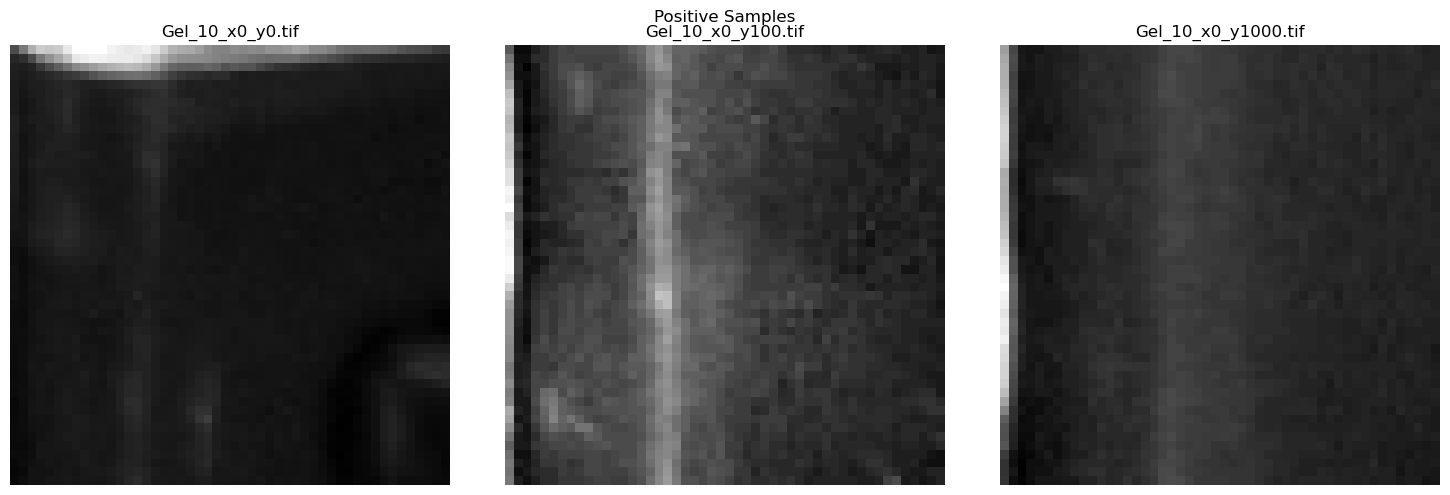

Showing examples from: Background Samples


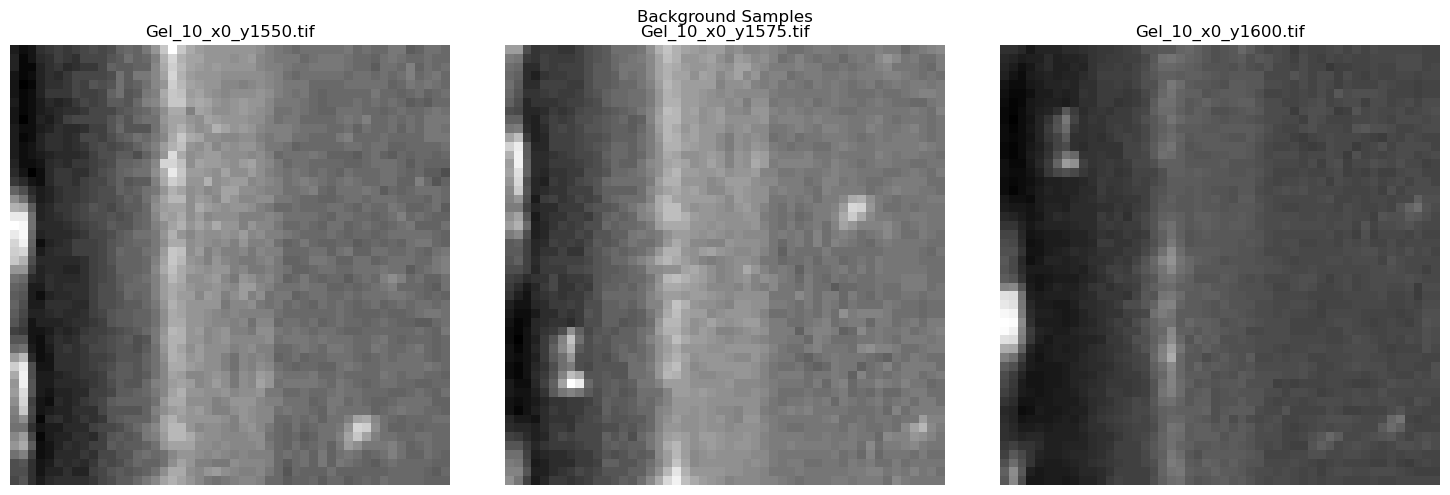

Showing examples from: Augmented Samples (Rotations)


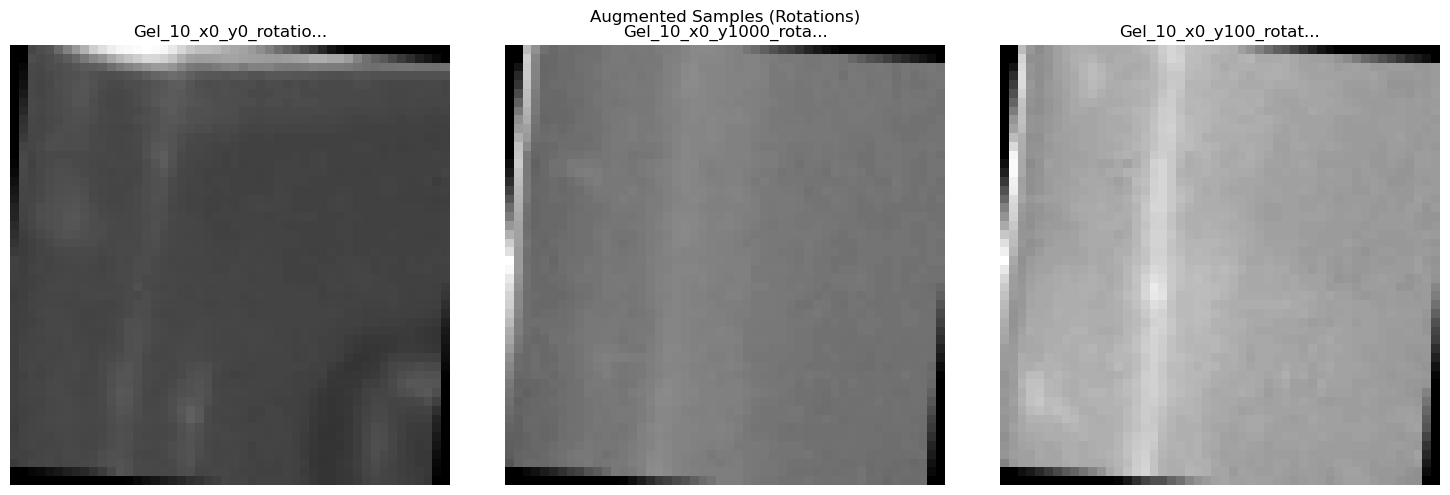

In [11]:
# Displaying Results and Summaries 
# Print summary for detected bands
print("Band Detection Results:")
band_locations_path = os.path.join(output_dir, "band_locations.csv")

# Count positive and background samples in the training dataset
pos_dir = os.path.join(training_dir, 'positive')
bg_dir = os.path.join(training_dir, 'background')

if os.path.exists(pos_dir) and os.path.exists(bg_dir):
    positive_samples = len([f for f in os.listdir(pos_dir) if f.endswith('.tif')])
    background_samples = len([f for f in os.listdir(bg_dir) if f.endswith('.tif')])
    print(f"\nTraining Data Summary:")
    print(f"- Positive samples: {positive_samples}")
    print(f"- Background samples: {background_samples}")

# Count total augmented training samples
aug_dir = os.path.join(augmented_dir, 'training')
if os.path.exists(aug_dir):
    augmented_samples = len([f for f in os.listdir(aug_dir) if f.endswith('.tif')])
    print(f"\nAugmented Data:")
    print(f"- Total augmented samples: {augmented_samples}")

# Define a utility function to show a few example images from a given directory
def show_examples(title, directory, count=3):
    files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    files = files[:count]
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    
    for i, file in enumerate(files):
        plt.subplot(1, count, i+1)
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            plt.imshow(img, cmap='gray')
            plt.title(file[:20] + '...' if len(file) > 20 else file)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show example images from different datasets
print("\nDisplaying example images:")
for dir_name, dir_path in [
    ("Positive Samples", pos_dir),
    ("Background Samples", bg_dir),
    ("Augmented Samples (Rotations)", os.path.join(augmented_dir, 'rotations'))
]:
    if os.path.exists(dir_path) and any(f.endswith('.tif') for f in os.listdir(dir_path)):
        print(f"Showing examples from: {dir_name}")
        show_examples(dir_name, dir_path)

In [ ]:
# Model Part
# Random Forest
# XGBoost

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [18]:
# Prepare data for model training
def prepare_model_data(training_dir, metadata_path=None):
    
    # Load data from metadata if available
    if metadata_path and os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        
        positive_dir = os.path.join(training_dir, 'positive')
        background_dir = os.path.join(training_dir, 'background')
        
        all_features = []
        all_labels = []
        
        # Positive samples
        if os.path.exists(positive_dir):
            for file in os.listdir(positive_dir):
                if file.endswith('.tif'):
                    img_path = os.path.join(positive_dir, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    features = extract_features(img)
                    all_features.append(features)
                    all_labels.append(1)  # Label for positive
        
        # Background samples
        if os.path.exists(background_dir):
            for file in os.listdir(background_dir):
                if file.endswith('.tif'):
                    img_path = os.path.join(background_dir, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    features = extract_features(img)
                    all_features.append(features)
                    all_labels.append(0)  # Label for background
    else:
        # Load data directly from training folder
        positive_dir = os.path.join(training_dir, 'positive')
        background_dir = os.path.join(training_dir, 'background')
        
        all_features = []
        all_labels = []
        
        if os.path.exists(positive_dir):
            for file in os.listdir(positive_dir):
                if file.endswith('.tif'):
                    img_path = os.path.join(positive_dir, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    features = extract_features(img)
                    all_features.append(features)
                    all_labels.append(1)
        
        if os.path.exists(background_dir):
            for file in os.listdir(background_dir):
                if file.endswith('.tif'):
                    img_path = os.path.join(background_dir, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    features = extract_features(img)
                    all_features.append(features)
                    all_labels.append(0)
    
    # Convert to numpy arrays
    X = np.array(all_features)
    y = np.array(all_labels)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test

def extract_features(img):
    
    # Basic statistics
    mean = np.mean(img)
    std = np.std(img)
    median = np.median(img)
    min_val = np.min(img)
    max_val = np.max(img)
    
    # Histogram features
    hist = cv2.calcHist([img], [0], None, [10], [0, 256])
    hist_features = hist.flatten() / np.sum(hist)  # Normalize
    
    # Gradient features
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_mean = np.mean(gradient_magnitude)
    gradient_std = np.std(gradient_magnitude)
    
    # Combine all features
    features = [mean, std, median, min_val, max_val, 
                gradient_mean, gradient_std]
    features.extend(hist_features)
    
    return features

In [20]:
# Train and evaluate Random Forest model
def train_random_forest(X_train, y_train, X_test, y_test):
    print("\n=== Training Random Forest Model ===")
    
    # Parameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Create base model
    rf = RandomForestClassifier(random_state=42)
    
    # Use GridSearchCV to find best parameters
    grid_search = GridSearchCV(
        estimator=rf, 
        param_grid=param_grid, 
        cv=5,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=1, 
        scoring='accuracy'
    )
    
    # Train the model
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_rf = grid_search.best_estimator_
    
    # Print best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Background', 'Band'],
                yticklabels=['Background', 'Band'])
    plt.title('Confusion Matrix - Random Forest')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Feature importance
    if hasattr(best_rf, 'feature_importances_'):
        importances = best_rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances - Random Forest')
        plt.bar(range(min(20, len(importances))), importances[indices[:20]], 
                align='center')
        plt.xticks(range(min(20, len(importances))), indices[:20])
        plt.tight_layout()
        plt.show()
    
    return best_rf

In [21]:
# Train and evaluate XGBoost model
def train_xgboost(X_train, y_train, X_test, y_test):
    print("\n=== Training XGBoost Model ===")
    
    # Parameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    # Create base model
    xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False,
                                 eval_metric='logloss')
    
    # Use GridSearchCV to find best parameters
    grid_search = GridSearchCV(
        estimator=xgb_model, 
        param_grid=param_grid, 
        cv=5,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=1, 
        scoring='accuracy'
    )
    
    # Train the model
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_xgb = grid_search.best_estimator_
    
    # Print best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred = best_xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Background', 'Band'],
                yticklabels=['Background', 'Band'])
    plt.title('Confusion Matrix - XGBoost')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Feature importance
    if hasattr(best_xgb, 'feature_importances_'):
        importances = best_xgb.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances - XGBoost')
        plt.bar(range(min(20, len(importances))), importances[indices[:20]], 
                align='center')
        plt.xticks(range(min(20, len(importances))), indices[:20])
        plt.tight_layout()
        plt.show()
    
    return best_xgb

Training samples: 69611
Testing samples: 17403

=== Training Random Forest Model ===
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9997
Test accuracy: 0.9997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12862
           1       1.00      1.00      1.00      4541

    accuracy                           1.00     17403
   macro avg       1.00      1.00      1.00     17403
weighted avg       1.00      1.00      1.00     17403



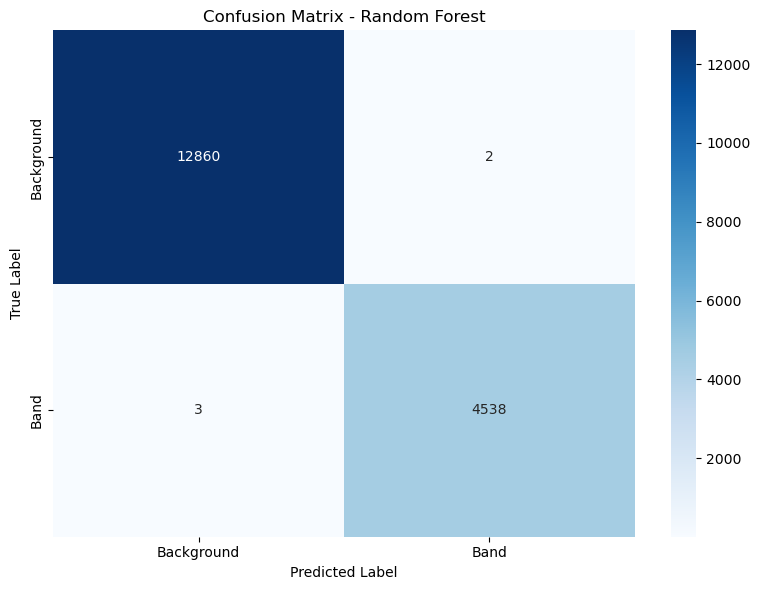

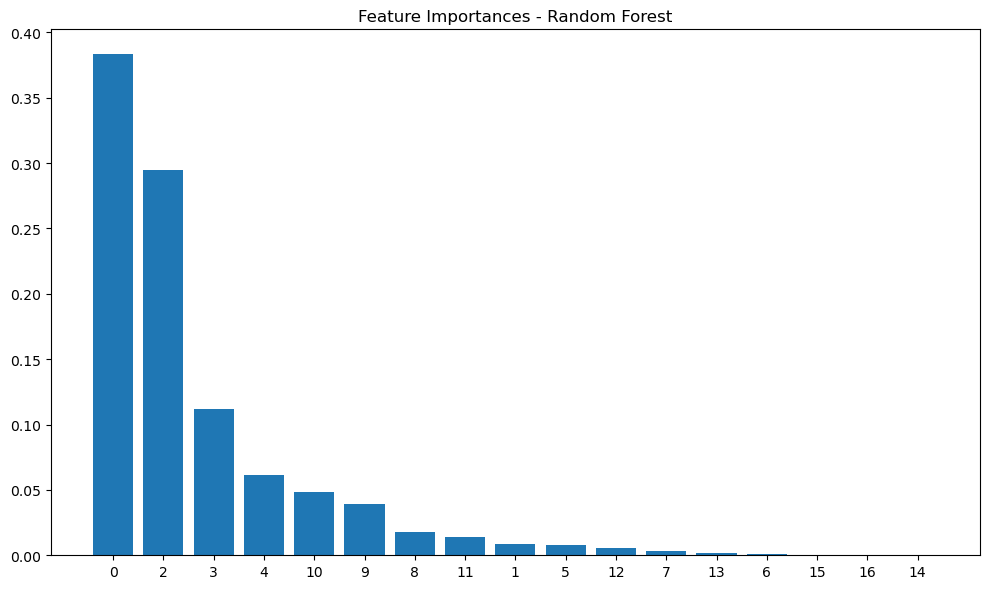


=== Training XGBoost Model ===
Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\lolo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.9990
Test accuracy: 0.9986

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12862
           1       1.00      1.00      1.00      4541

    accuracy                           1.00     17403
   macro avg       1.00      1.00      1.00     17403
weighted avg       1.00      1.00      1.00     17403



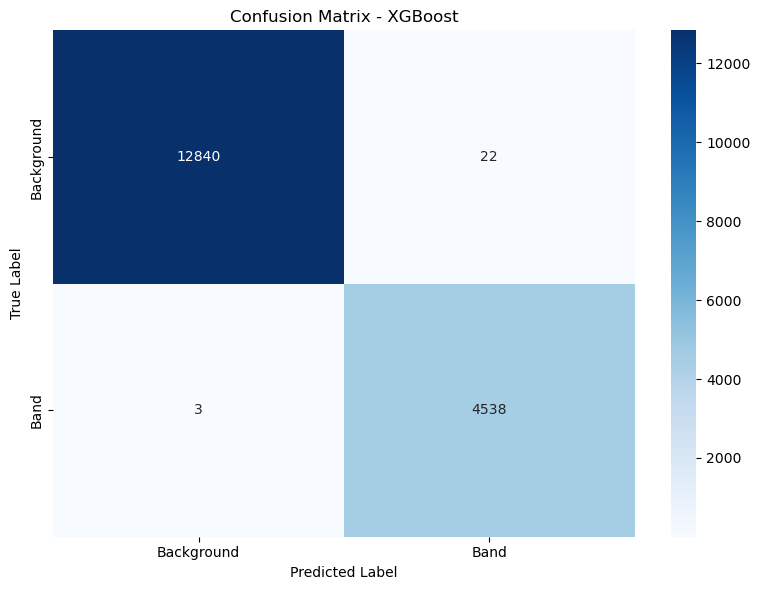

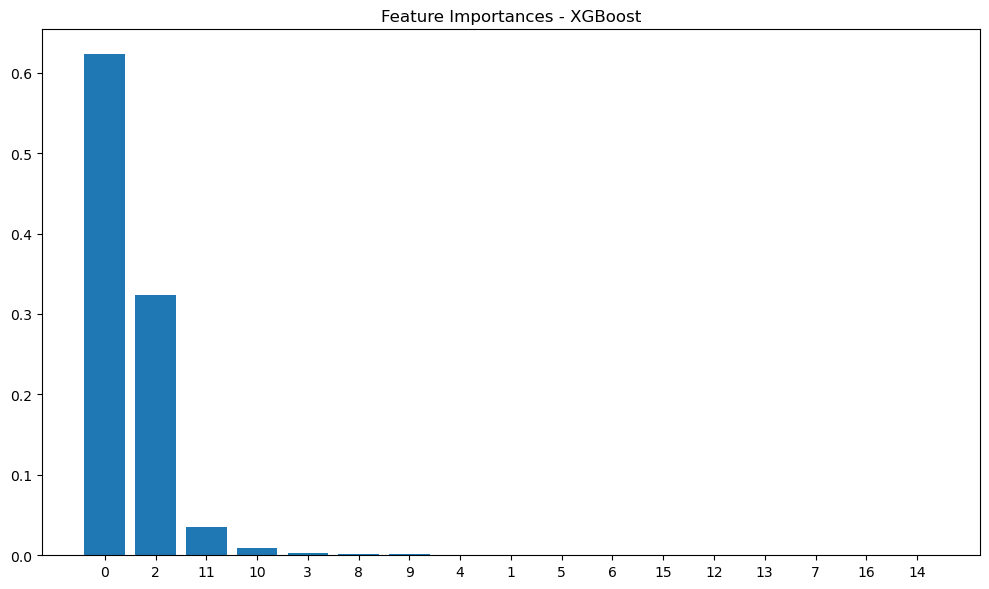


=== Model Comparison ===
Random Forest Accuracy: 0.9997
XGBoost Accuracy: 0.9986


In [23]:
# Run model training and evaluation
X_train, X_test, y_train, y_test = prepare_model_data(training_dir)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate Random Forest model
rf_model = train_random_forest(X_train_scaled, y_train, X_test_scaled, y_test)

# Train and evaluate XGBoost model
xgb_model = train_xgboost(X_train_scaled, y_train, X_test_scaled, y_test)

# Compare the two models
rf_preds = rf_model.predict(X_test_scaled)
xgb_preds = xgb_model.predict(X_test_scaled)

print("\n=== Model Comparison ===")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_preds):.4f}")

# Save models
import pickle
os.makedirs(os.path.join(output_dir, 'models'), exist_ok=True)

with open(os.path.join(output_dir, 'models', 'random_forest_model.pkl'), 'wb') as f:
    pickle.dump(rf_model, f)

with open(os.path.join(output_dir, 'models', 'xgboost_model.pkl'), 'wb') as f:
    pickle.dump(xgb_model, f)

with open(os.path.join(output_dir, 'models', 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)


Predicting on image: Gel_10_x0_y0_rotations.tif


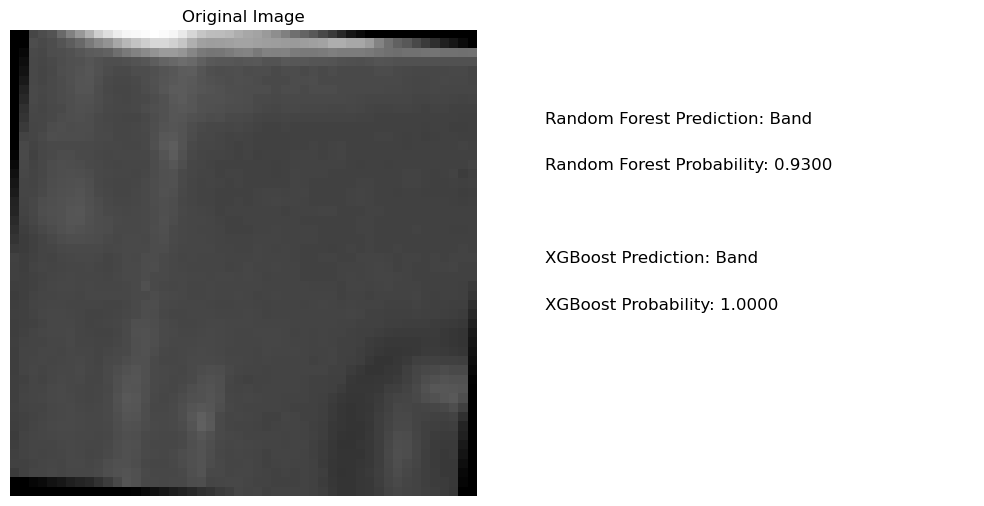


Predicting on image: Gel_10_x0_y1000_rotations.tif


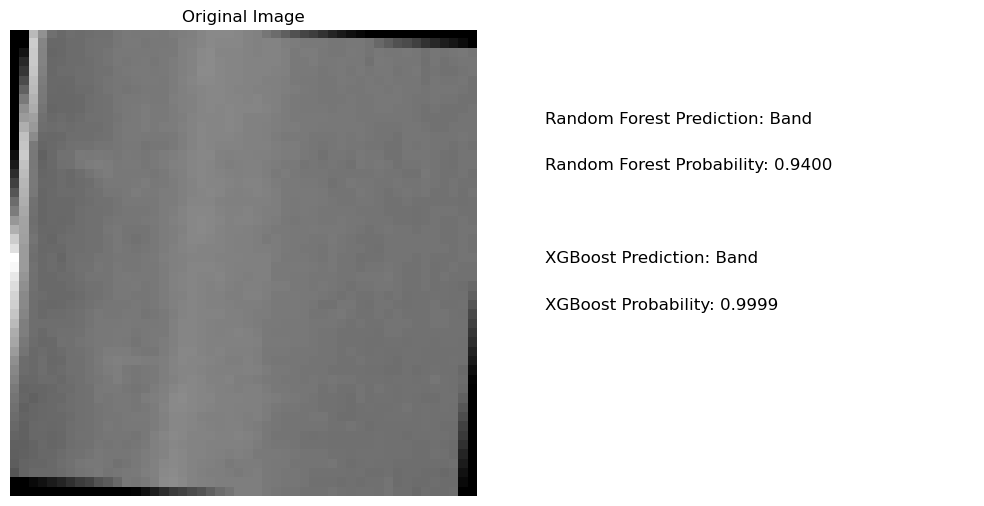


Predicting on image: Gel_10_x0_y100_rotations.tif


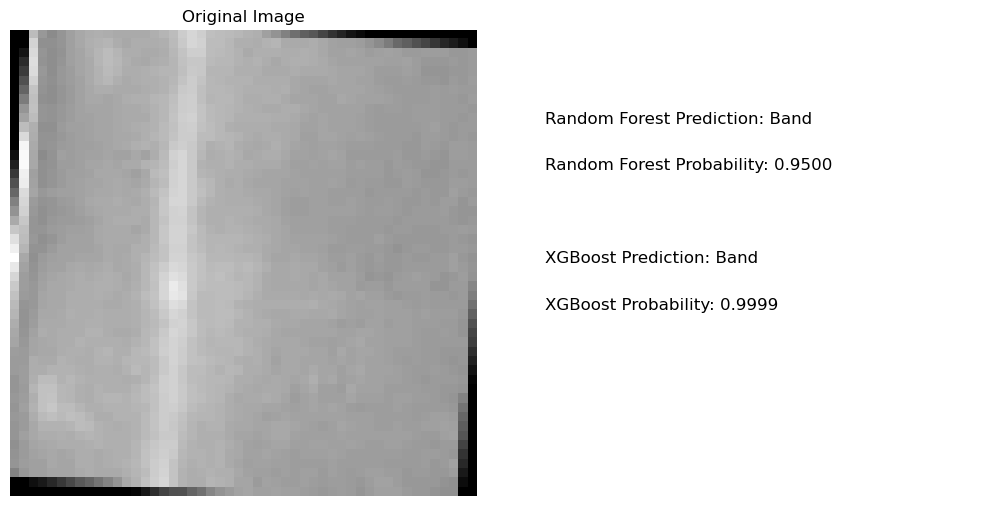

In [24]:
# Apply models to new images
def predict_on_new_image(image_path, rf_model, xgb_model, scaler):

    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Extract features
    features = extract_features(img)
    features = np.array([features])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make predictions
    rf_pred = rf_model.predict(features_scaled)[0]
    rf_prob = rf_model.predict_proba(features_scaled)[0]
    
    xgb_pred = xgb_model.predict(features_scaled)[0]
    xgb_prob = xgb_model.predict_proba(features_scaled)[0]
    
    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.8, f"Random Forest Prediction: {'Band' if rf_pred == 1 else 'Background'}", 
             fontsize=12)
    plt.text(0.1, 0.7, f"Random Forest Probability: {rf_prob[rf_pred]:.4f}", fontsize=12)
    plt.text(0.1, 0.5, f"XGBoost Prediction: {'Band' if xgb_pred == 1 else 'Background'}", 
             fontsize=12)
    plt.text(0.1, 0.4, f"XGBoost Probability: {xgb_prob[xgb_pred]:.4f}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test on sample images
test_images_dir = os.path.join(augmented_dir, 'rotations')
if os.path.exists(test_images_dir):
    test_files = [f for f in os.listdir(test_images_dir) if f.endswith('.tif')][:3]
    for test_file in test_files:
        test_path = os.path.join(test_images_dir, test_file)
        print(f"\nPredicting on image: {test_file}")
        predict_on_new_image(test_path, rf_model, xgb_model, scaler)


=== Comparing Models with IOU Score ===

--- Random Forest Evaluation ---
Accuracy: 0.9997
IOU Score: 0.9989
Precision: 0.9996
Recall: 0.9993
F1 Score: 0.9994


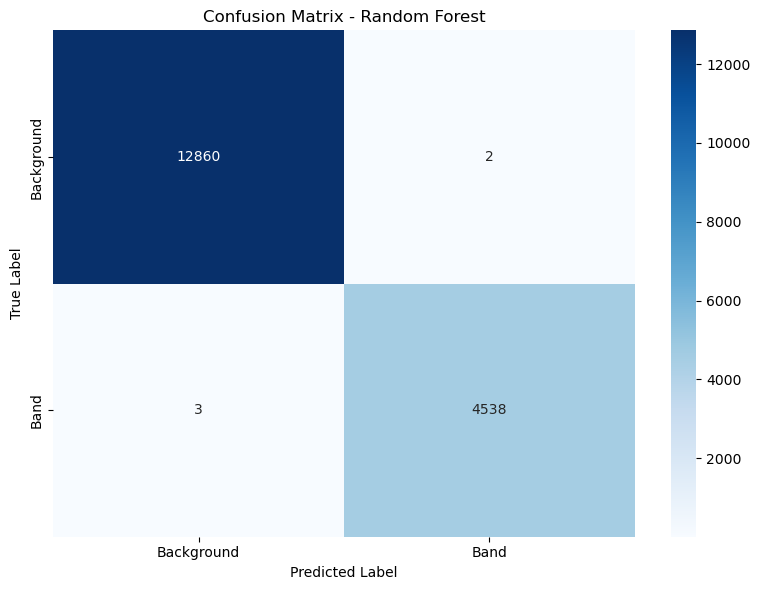


--- XGBoost Evaluation ---
Accuracy: 0.9986
IOU Score: 0.9945
Precision: 0.9952
Recall: 0.9993
F1 Score: 0.9973


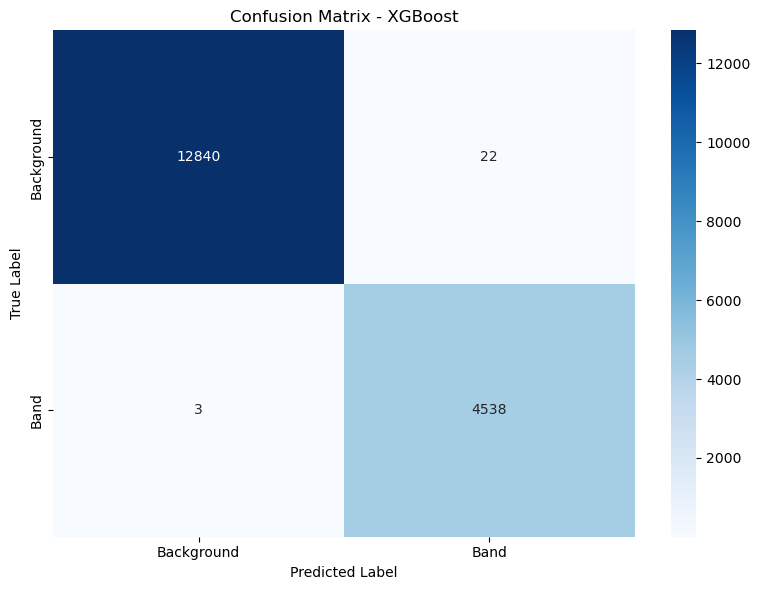


=== Model Comparison ===
           Random Forest   XGBoost
accuracy        0.999713  0.998563
iou             0.998899  0.994521
precision       0.999559  0.995175
recall          0.999339  0.999339
f1              0.999449  0.997253


<Figure size 1000x600 with 0 Axes>

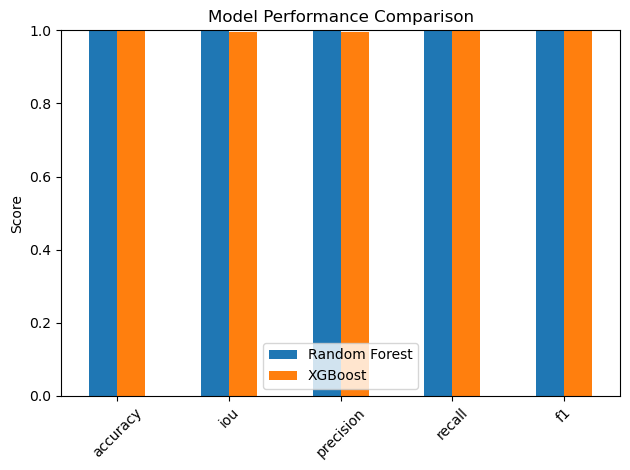

In [26]:
from sklearn.metrics import jaccard_score

def calculate_iou(y_true, y_pred):
    
    # For binary classification
    return jaccard_score(y_true, y_pred, average='binary')

def predict_and_evaluate(model, X_test, y_test, threshold=0.5, name="Model"):
    
    # Get probability predictions
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Convert to binary predictions based on threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    iou = calculate_iou(y_test, y_pred)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate precision, recall, and F1 score
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Print results
    print(f"\n--- {name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"IOU Score: {iou:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Background', 'Band'],
                yticklabels=['Background', 'Band'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'iou': iou,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Compare models
print("\n=== Comparing Models with IOU Score ===")
rf_metrics = predict_and_evaluate(rf_model, X_test_scaled, y_test, name="Random Forest")
xgb_metrics = predict_and_evaluate(xgb_model, X_test_scaled, y_test, name="XGBoost")

# Compare models
models = ['Random Forest', 'XGBoost']
metrics = ['accuracy', 'iou', 'precision', 'recall', 'f1']
comparison = pd.DataFrame({
    'Random Forest': [rf_metrics[m] for m in metrics],
    'XGBoost': [xgb_metrics[m] for m in metrics]
}, index=metrics)

print("\n=== Model Comparison ===")
print(comparison)

# Plot comparison
plt.figure(figsize=(10, 6))
comparison.plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== Evaluating Random Forest on Full Image ===


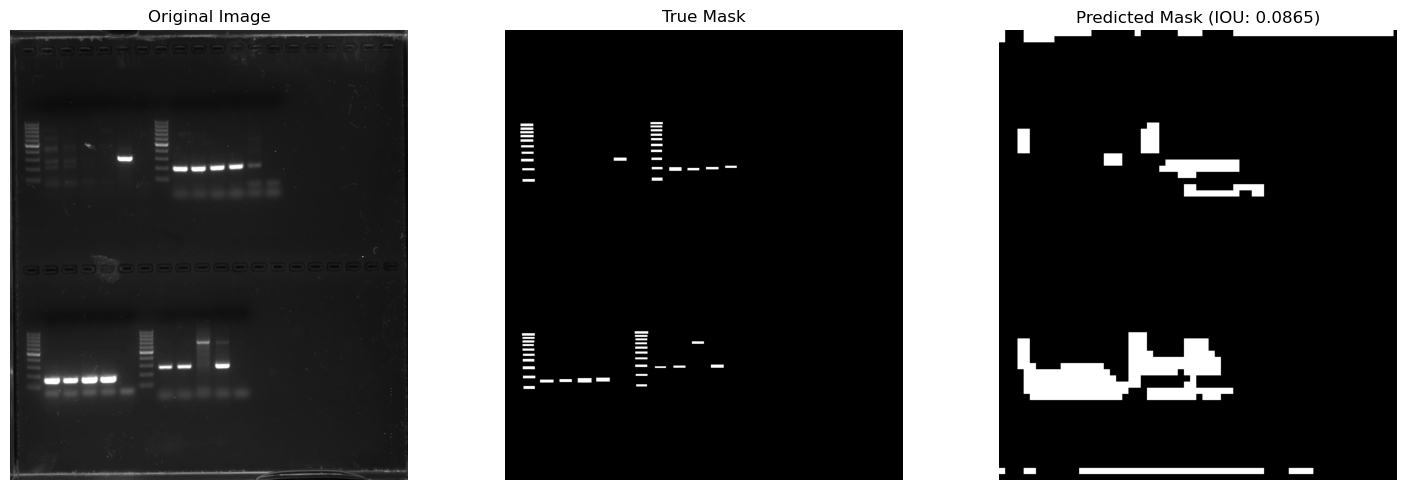


=== Evaluating XGBoost on Full Image ===


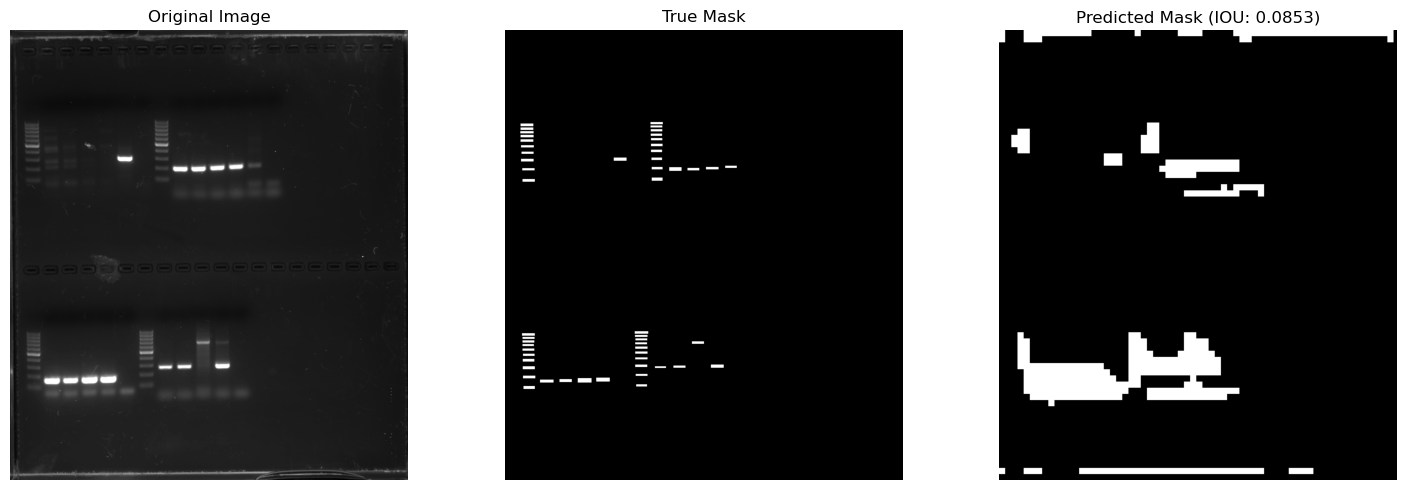


Full Image IOU Scores:
Random Forest: 0.0865
XGBoost: 0.0853


In [27]:
def reconstruct_and_evaluate_full_image(model, original_image, true_mask, window_size=50, stride=25, scaler=None):

    # Create empty prediction mask
    height, width = original_image.shape
    pred_mask = np.zeros((height, width), dtype=np.float32)
    counts = np.zeros((height, width), dtype=np.int32)
    
    # Slide window across image
    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            # Extract window
            window = original_image[y:y+window_size, x:x+window_size]
            
            # Extract features
            features = extract_features(window)
            features = np.array([features])
            
            # Scale features
            if scaler:
                features = scaler.transform(features)
            
            # Predict
            pred = model.predict_proba(features)[0, 1]
            
            # Add prediction to mask
            pred_mask[y:y+window_size, x:x+window_size] += pred
            counts[y:y+window_size, x:x+window_size] += 1
    
    # Average overlapping predictions
    # Avoid division by zero
    mask = counts > 0
    pred_mask[mask] = pred_mask[mask] / counts[mask]
    
    # Convert to binary
    binary_pred_mask = (pred_mask > 0.5).astype(np.uint8)
    binary_true_mask = true_mask.astype(np.uint8)
    
    # Calculate IOU for the full image
    intersection = np.logical_and(binary_pred_mask, binary_true_mask).sum()
    union = np.logical_or(binary_pred_mask, binary_true_mask).sum()
    iou = intersection / union if union > 0 else 0
    
    # Visualize
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(binary_true_mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(binary_pred_mask, cmap='gray')
    plt.title(f'Predicted Mask (IOU: {iou:.4f})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return iou

# Example usage (if you have full images available)
# Load a test image and its mask
test_image_path = os.path.join(raw_dir, "Gel_1.tif")
test_mask_path = os.path.join(mask_dir, "Mask_1.tif")

if os.path.exists(test_image_path) and os.path.exists(test_mask_path):
    # Load image and mask
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
    test_mask = np.where(test_mask > 0, 1, 0)  # Binarize mask
    
    # Evaluate Random Forest on full image
    print("\n=== Evaluating Random Forest on Full Image ===")
    rf_image_iou = reconstruct_and_evaluate_full_image(
        rf_model, test_image, test_mask, 
        window_size=50, stride=25, scaler=scaler
    )
    
    # Evaluate XGBoost on full image
    print("\n=== Evaluating XGBoost on Full Image ===")
    xgb_image_iou = reconstruct_and_evaluate_full_image(
        xgb_model, test_image, test_mask, 
        window_size=50, stride=25, scaler=scaler
    )
    
    print(f"\nFull Image IOU Scores:")
    print(f"Random Forest: {rf_image_iou:.4f}")
    print(f"XGBoost: {xgb_image_iou:.4f}")
else:
    print("Test image or mask not found. Skipping full image evaluation.")